<a href="https://colab.research.google.com/github/szhang12345/MSDS-422-Assignment-1---Exploratory-Data-Analysis/blob/main/Assignment1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MSDS 422 Assignment 1: Exploring and Visualizing Data**

**By Siying Zhang**


**Topic:** The spread of COVID 19 (incidence) and its fatality rate 

**Data Source**

https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

*CoLab Shared Link - this notebook*
https://colab.research.google.com/drive/1gaq5O6_R95mr2VIYfuL_JeBj-2jszPLV

**Table of contents:**

Ingest (System & Data Preparation)
*   Load Relevant Packages
*   Load Data from CSV
*   Rename Columns and Reformat Data
*   Drop Negative Values
*   Drop Missing Values

EDA
*   Features Creation
*   Incidence and Fatality by Continent
*   Top Incidence and Fatality Countries
*   The Spread of Incidences and Fatality - Time Series Analysis
*   Univariate Distribution of Weekly Incidence and Fatality
*   Bivariate Distribution of Weekly Incidence and Fatality by Continent

Modeling (Data scaling and comparisons)
*   Standard Scaling
*   Min-max Scaling
*   Comparison

Conclusion (Insights from analysis)

# Ingest


Load relevant packages

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots  
import seaborn as sns  
import io
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
# suppress warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Load data from the csv and gather descriptive information of dataframe

In [ ]:
url = 'https://raw.githubusercontent.com/szhang12345/MSDS-422-Assignment-1---Exploratory-Data-Analysis/57b56c4ad3a0de4558f2044d0ce30e072ba1bca8/data.csv'
df = pd.read_csv(url)

In [ ]:
df.head()
df.info()
df.describe()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9577 entries, 0 to 9576
Data columns (total 10 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   dateRep                                          9577 non-null   object 
 1   year_week                                        9577 non-null   object 
 2   cases_weekly                                     9577 non-null   int64  
 3   deaths_weekly                                    9577 non-null   int64  
 4   countriesAndTerritories                          9577 non-null   object 
 5   geoId                                            9534 non-null   object 
 6   countryterritoryCode                             9556 non-null   object 
 7   popData2019                                      9556 non-null   float64
 8   continentExp                                     9577 non-null   object 
 9   notification_rate_per_100000_p

(9577, 10)

Rename Columns Reformat Data


In [ ]:
'''based on calculation, it appears that notification_rate_per_100000_population_14-days is 14 days cases per 100k population by country
, shorten the variable/column names for variables to reflect info'''
df = df.rename(index=str, columns={
    'dateRep': 'date',
    'year_week': 'yweek',
    'cases_weekly': 'cases_weekly',
    'deaths_weekly': 'deaths_weekly',
    'countriesAndTerritories': 'country',
        'geoId': 'geoId',
    'countryterritoryCode': 'countrycode',
        'popData2019': 'pop2019',
    'continentExp': 'continent',
        'continentExp': 'continent',
    'notification_rate_per_100000_population_14-days': 'cases_14d_per_100k'})
df['date'] = pd.to_datetime(df.date, infer_datetime_format=True)
df['date'] = df['date'].replace(pd.to_datetime('2021-04-01'), 
                                pd.to_datetime('2021-01-04'))
df = df.sort_values(['country','date'])

Drop Negative Values

In [ ]:
'''description indicates there are negative numbers in variables cases_weekly and deaths_weekly,
which could be data collection error, drop negative values to improve data quality'''
df=df.drop(df[(df.cases_weekly<0)|(df.deaths_weekly<0)].index)

Drop Missing Values

In [ ]:
'''description indicates there are missing values in pop2019, since missing value compose small portion, 
drop rows with missing values in pop2019 to improve data quality'''
df=df.dropna(subset=["pop2019"])
df.shape

(9547, 10)

# EDA


Features Creation

In [ ]:
#Create weekly case rate and death rate per million in the population
df['case_rate_weekly_per_1m']=df['cases_weekly']*1000000/df['pop2019']
df['death_rate_weekly_per_1m']=df['deaths_weekly']*1000000/df['pop2019']
#Create cumulative cases and deaths in each country by using groupby-apply
df['totalcases'] = df.groupby(['country'])['cases_weekly'].apply(lambda x: x.cumsum())
df['totaldeaths'] = df.groupby(['country'])['deaths_weekly'].apply(lambda x: x.cumsum())
df.describe()


,cases_weekly,deaths_weekly,pop2019,cases_14d_per_100k,case_rate_weekly_per_1m,death_rate_weekly_per_1m,totalcases,totaldeaths
count,9.547000e+03,9547.000000,9.547000e+03,9335.000000,9547.000000,9547.000000,9.547000e+03,9547.000000
mean,8.854339e+03,193.037603,4.055270e+07,74.874730,377.163400,6.380612,1.508003e+05,3899.196920
std,5.281427e+04,894.420709,1.518100e+08,180.164673,941.155759,17.508973,7.939865e+05,17781.508631
min,0.000000e+00,0.000000,8.150000e+02,-131.620000,0.000000,0.000000,0.000000e+00,0.000000
25%,8.000000e+00,0.000000,1.293120e+06,0.775000,2.665945,0.000000,7.170000e+02,12.000000
50%,1.610000e+02,2.000000,7.169456e+06,7.340000,33.822481,0.247453,7.587000e+03,108.000000
75%,2.279000e+03,36.000000,2.851583e+07,59.025000,289.600348,3.766783,5.953850e+04,1001.000000
max,1.588085e+06,18574.000000,1.433784e+09,3447.460000,20767.815819,458.453713,2.064021e+07,351590.000000


Descriptive Statistics of Incidence and Fatality by Continent

In [ ]:
continent_stat = df.groupby('continent').agg({'cases_weekly': ['mean', 'max', 'sum'], 'deaths_weekly': ['mean', 'max', 'sum']})
continent_stat.columns = ['cases_weekly_mean', 'cases_weekly_max', 'cases_weekly_sum','deaths_weekly_mean', 'deaths_weekly_max', 'deaths_weekly_sum']
continent_stat

,cases_weekly_mean,cases_weekly_max,cases_weekly_sum,deaths_weekly_mean,deaths_weekly_max,deaths_weekly_sum
continent,,,,,,
Africa,1215.843777,89949,2832916,28.873820,2506,67276
America,17457.077068,1588085,37148660,412.205357,18574,877173
Asia,8884.870398,641814,18098481,153.153166,8160,311973
Europe,9901.105401,373409,26396347,219.551388,6440,585324
Oceania,145.000000,3520,55970,3.067358,142,1184


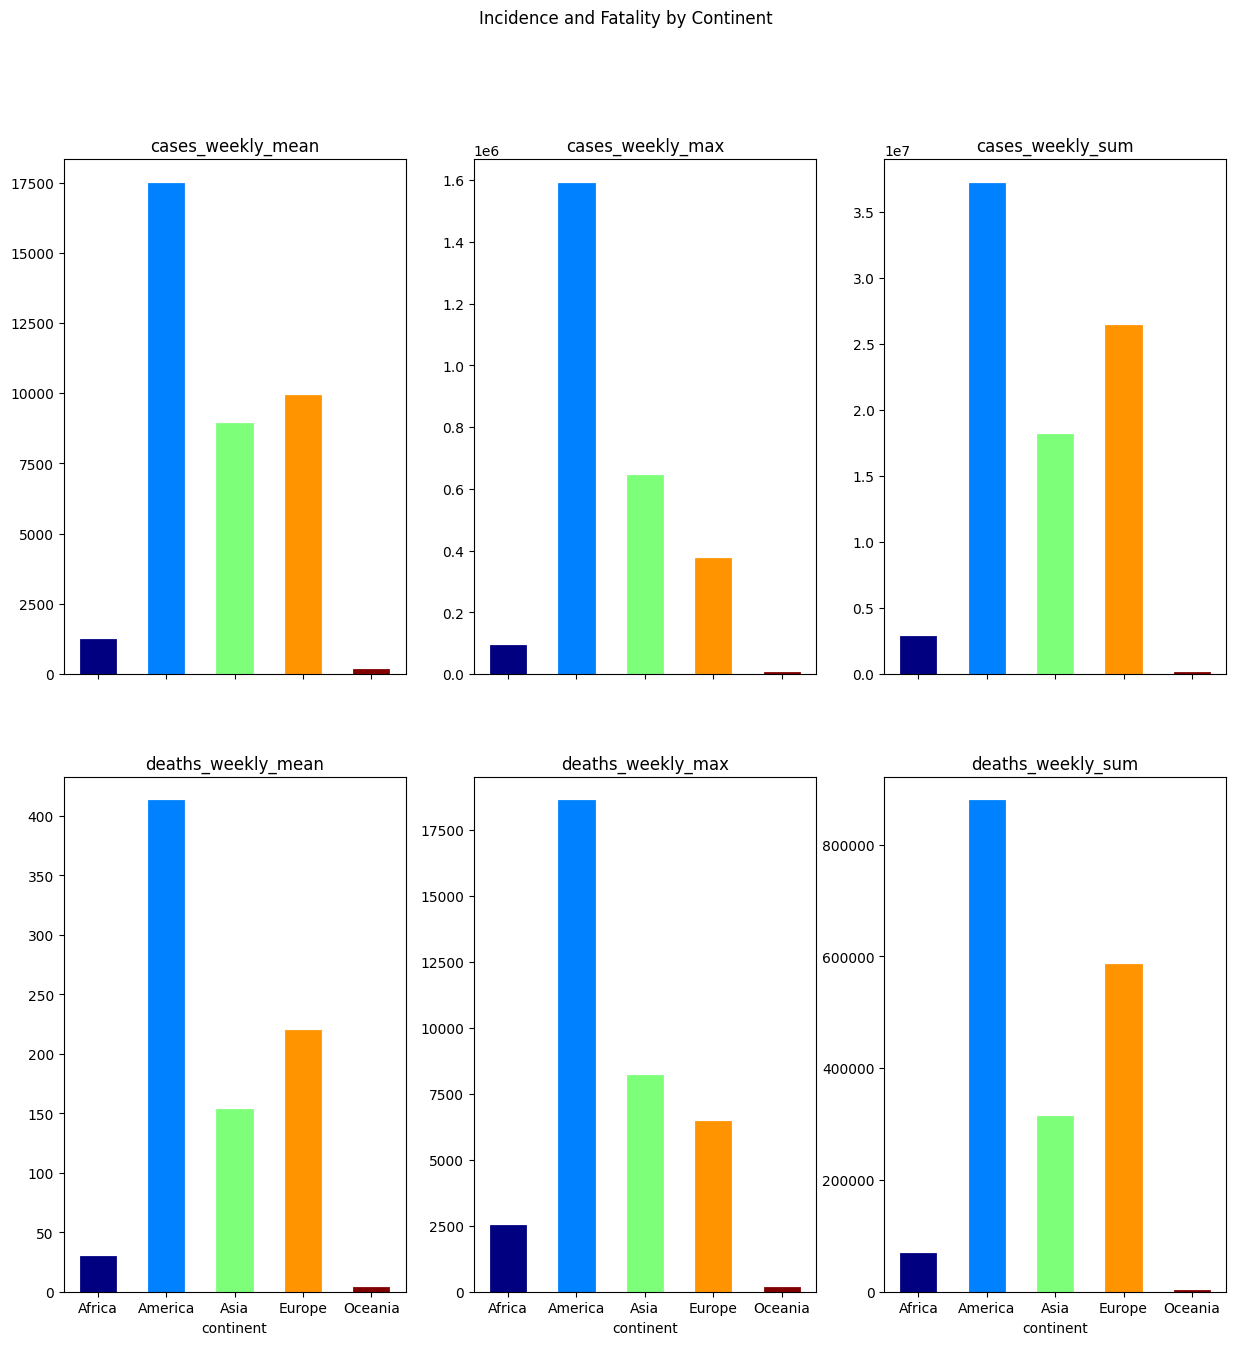

In [ ]:
labels = continent_stat.columns
axes = continent_stat.plot(kind='bar',rot=0,lw=2,colormap='jet',figsize=(15,15),
             title='Incidence and Fatality by Continent', subplots=True, layout=(2,3), legend=False)
colors = plt.cm.jet(np.linspace(0,1,len(continent_stat)))
for ax in axes.flat:
    for i,bar in enumerate(ax.patches):
        bar.set_color(colors[i])
plt.show()

Scatter Plot of Weekly Incidence and Fatality for each Country by Continent

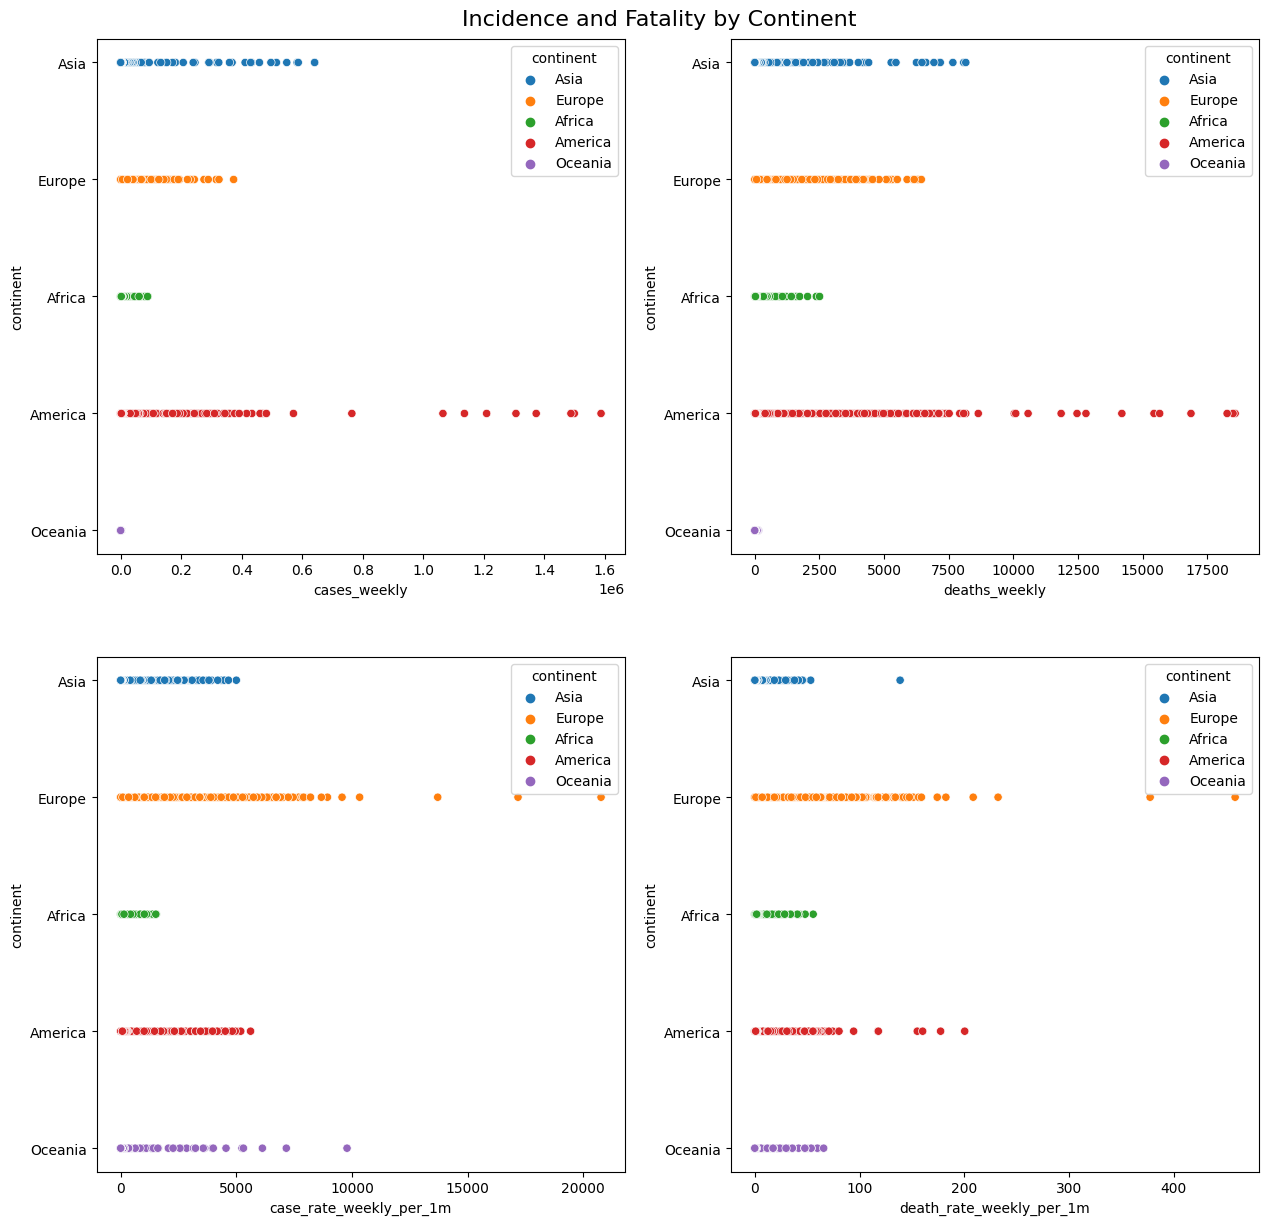

In [ ]:
#scatter plot weekly incidence and fatality for each country by continent as well as incidence rate and fatality rate for each country by continent in one graph
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=False)
f.suptitle('Incidence and Fatality by Continent', size = 16, y=.9)
sns.scatterplot(df["cases_weekly"] , df['continent'], hue=df['continent'], ax=axes[0, 0])
sns.scatterplot(df["deaths_weekly"] , df['continent'], hue=df['continent'], ax=axes[0, 1])
sns.scatterplot(df["case_rate_weekly_per_1m"] , df['continent'], hue=df['continent'], ax=axes[1, 0])
sns.scatterplot(df["death_rate_weekly_per_1m"], df['continent'], hue=df['continent'], ax=axes[1, 1])
f.savefig('Incidence and Fatality for each Country by Continent' + '.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)

Insight: From above statistics, it appears that America has the highest total number of instances and deaths between January 6, 2020 and January 4, 2021 and Europe ranks second.

Summary of Incidences and Fatality by Country

In [ ]:
summary = df.groupby('country')\
            .agg({'cases_weekly':np.sum,'deaths_weekly':np.sum,'pop2019':np.mean})\
            .reset_index().sort_values('cases_weekly',ascending=False)
summary['ratio'] = summary.deaths_weekly/summary.cases_weekly
summary.columns=['country','cases','deaths','population','death ratio']
summary.set_index('country')

,cases,deaths,population,death ratio
country,,,,
United_States_of_America,20640214,351590,3.290649e+08,0.017034
India,10340469,149649,1.366418e+09,0.014472
Brazil,7733746,196018,2.110495e+08,0.025346
Russia,3260138,58988,1.458723e+08,0.018094
France,2655728,65037,6.701288e+07,0.024489
...,...,...,...,...
Solomon_Islands,17,0,6.698210e+05,0.000000
Anguilla,15,0,1.487200e+04,0.000000
Montserrat,13,1,4.991000e+03,0.076923


Top 10 Incidences Countries and Top 10 Deaths Countries

In [ ]:
s1=summary.nlargest(10,'cases').reset_index()
s2=summary.nlargest(10,'deaths').reset_index()
s=pd.concat([s1,s2], axis=1)
s.columns=['top10casesindex',	'top10cases_country',	'top10cases_cases', 'top10cases_deaths',	'top10cases_population',	'top10cases_death ratio',	'top10deathsindex', 'top10deaths_country',	'top10deaths_cases', 'top10deaths_deaths',	'top10deaths_population',	'top10deaths_death ratio']
s

,top10casesindex,top10cases_country,top10cases_cases,top10cases_deaths,top10cases_population,top10cases_death ratio,top10deathsindex,top10deaths_country,top10deaths_cases,top10deaths_deaths,top10deaths_population,top10deaths_death ratio
0,202,United_States_of_America,20640214,351590,3.290649e+08,0.017034,202,United_States_of_America,20640214,351590,3.290649e+08,0.017034
1,91,India,10340469,149649,1.366418e+09,0.014472,27,Brazil,7733746,196018,2.110495e+08,0.025346
2,27,Brazil,7733746,196018,2.110495e+08,0.025346,91,India,10340469,149649,1.366418e+09,0.014472
3,159,Russia,3260138,58988,1.458723e+08,0.018094,126,Mexico,1448755,127213,1.275755e+08,0.087808
4,69,France,2655728,65037,6.701288e+07,0.024489,98,Italy,2155446,75332,6.035955e+07,0.034950
5,199,United_Kingdom,2654779,75024,6.664711e+07,0.028260,199,United_Kingdom,2654779,75024,6.664711e+07,0.028260
6,98,Italy,2155446,75332,6.035955e+07,0.034950,69,France,2655728,65037,6.701288e+07,0.024489
7,180,Spain,1955050,51953,4.693706e+07,0.026574,159,Russia,3260138,58988,1.458723e+08,0.018094
8,74,Germany,1775513,34574,8.301921e+07,0.019473,93,Iran,1243434,55540,8.291389e+07,0.044667
9,42,Colombia,1675820,43965,5.033944e+07,0.026235,180,Spain,1955050,51953,4.693706e+07,0.026574


Insight: Among top 10 countries with highest number of cases, Italy has the highest death ratio of 0.03495; on the other hand, among top 10 countries with highest number of cdeaths, Mexico has the highest death ratio of 0.087808

Top 10 Cases Countries (Horizontal Bar Plot)

In [ ]:
s1=s1.sort_values('cases',ascending=True)
fig1 = px.bar(s1, y = 'country', x = 'cases', height = 600, color = 'death ratio', orientation = 'h',
                color_continuous_scale = px.colors.sequential.Viridis,title = 'Top 10 Cases Countries')
fig1.show()

Insight: USA has the highest number of cases and is followed by India and Brazil. Notably, Italy has the highest death ratio among top 10 countries with most cases. On the other hand, though India ranked second in terms of total case numbers, its death ratio is the lowest among top 10 countries.

Top 10 Deaths Countries (Horizontal Bar Plot)

In [ ]:
s2=s2.sort_values('deaths',ascending=True)
fig2 = px.bar(s2, y = 'country', x = 'deaths', height = 600, color = 'death ratio', orientation = 'h',
                color_continuous_scale = px.colors.sequential.Viridis,title = 'Top 10 Deaths Countries')
fig2.show()

Insight: USA has the highest number of deaths and is followed by Brazil and India. Notably, though Mexico does not rank as top 10 countries with highest number of cases, it has high numbers of total deaths and is ranked at the fourth place. The death ratio of Mexico is higher than 0.08 and is the highest one among top 10 countries with most deaths.

The Spread of Incidences and Fatality - Time Series Analysis

In [ ]:
time_series_dates = df.groupby('date').sum()
time_series_dates

,cases_weekly,deaths_weekly,pop2019,cases_14d_per_100k,case_rate_weekly_per_1m,death_rate_weekly_per_1m,totalcases,totaldeaths
date,,,,,,,,
2020-01-06,765215,28603,7.669216e+09,5266.69,27830.798015,516.625026,765215,28603
2020-01-13,1,1,5.800630e+09,0.00,0.014363,0.000697,592486,25208
2020-01-20,180,2,5.800630e+09,0.01,0.172357,0.001395,592666,25210
2020-01-27,2581,78,5.800630e+09,0.34,3.360131,0.054402,595247,25288
2020-02-03,9804,424,5.800630e+09,48.28,455.099723,30.756331,605051,25712
2020-02-11,3438731,46338,7.669945e+09,34160.09,181892.080071,1917.209550,4216512,75446
2020-02-17,30505,865,5.800630e+09,4.98,27.676524,0.666075,3407135,61106
2020-02-24,7670,841,5.800630e+09,5.48,27.580670,0.840975,3414805,61947
2020-03-02,14552,281,5.800630e+09,1.78,14.754938,0.204537,3429357,62228


Cumulative Cases Worldwide

In [ ]:
# Cumulative cases worldwide graph

cumcasefig = go.Figure()
cumcasefig.add_trace(go.Scatter(x = time_series_dates.index, y = time_series_dates['totalcases'], fill = 'tonexty',
                          line_color = 'blue'))
cumcasefig.update_layout(title = 'Cumulative Cases Worldwide')
cumcasefig.show()

Insight: The cumulative cases worldwide increased sharply since November 2020 with a steeper slope as presented in above graph.

Cumulative Deaths Worldwide

In [ ]:
# Cumulative Deaths worldwide graph

cumdeathfig = go.Figure()
cumdeathfig.add_trace(go.Scatter(x = time_series_dates.index, y = time_series_dates['totaldeaths'], fill = 'tonexty',
                          line_color = 'red'))
cumdeathfig.update_layout(title = 'Cumulative Deaths Worldwide')
cumdeathfig.show()

Insight: Similar to the observation from cumulative cases graph, the ramp up of deaths started in November 2020.

Weekly New Cases and Deaths Worldwide between January 2020 and January 2021

In [ ]:
#create new feature to present weekly death to case rate by time
time_series_dates['weekly_death_ratio']=time_series_dates['deaths_weekly']/time_series_dates['cases_weekly']

weeklyfig = make_subplots(
    rows=3, cols=1,
    subplot_titles=("Weekly New Cases Worldwide", "Weekly New Deaths Worldwide", "Weekly New Death to Case Rate Worldwide"))

weeklyfig.add_trace(go.Scatter(x = time_series_dates.index, y = time_series_dates['cases_weekly'], fill = 'tonexty',
                          line_color = 'gold'),row=1, col=1)
weeklyfig.add_trace(go.Scatter(x = time_series_dates.index, y = time_series_dates['deaths_weekly'], fill = 'tonexty',
                          line_color = 'green'),row=2, col=1)
weeklyfig.add_trace(go.Scatter(x = time_series_dates.index, y = time_series_dates['weekly_death_ratio'], fill = 'tonexty',
                          line_color = 'purple'),row=3, col=1)
weeklyfig.update_layout(height=800, width=800,
                  title_text="Weekly New Cases and Deaths Worldwide")
weeklyfig.show()

Insight: Weekly new cases and deaths numbers are varied across the time, however, there are several spikes for number of new cases and deaths. Notably, in the weeeks of July 12, 2020 and September 11, 2020, the new cases and deaths reached a high level. And also, since November 2020, both weekly new cases and deaths numbers are higher in general. In terms of weekly new death to case rate, there are several outstanding weeks across the year of 2020, such as in the weeks of February 24, 2020, April 20, 2020 and November 5, 2020, to name a few. 

Univariate Distribution of Weekly Incidence and Fatality

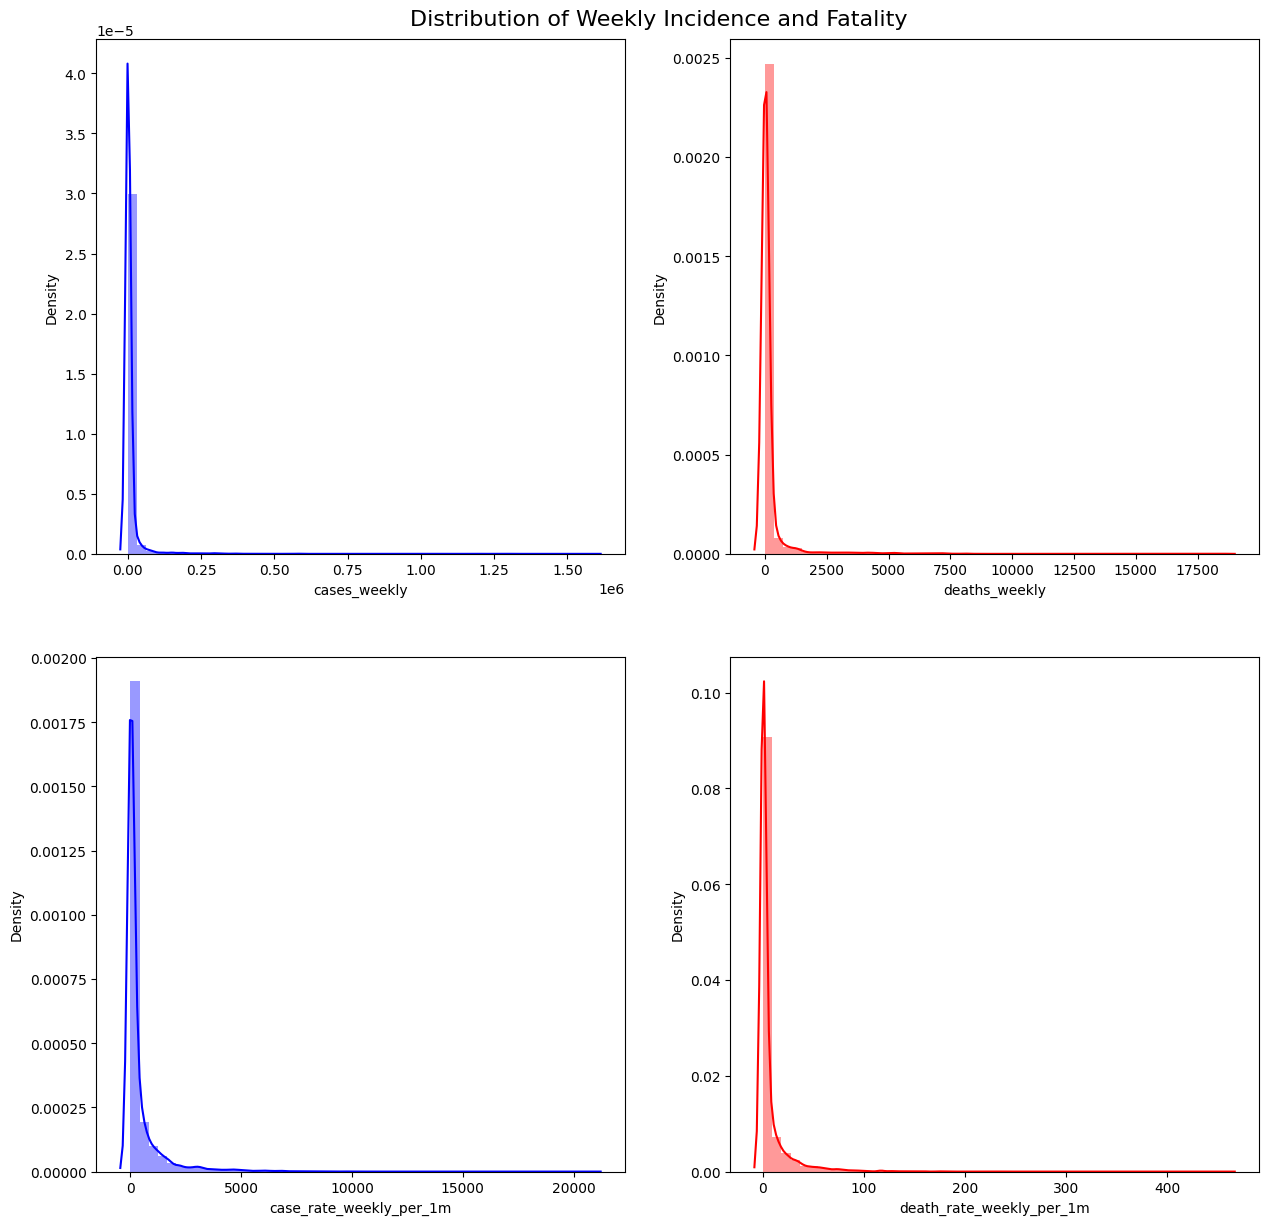

In [ ]:
#plot distribution of weekly incidence and fatality as well as incidence rate and fatality rate in one graph
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=False)
f.suptitle('Distribution of Weekly Incidence and Fatality', size = 16, y=.9)
sns.distplot(df["cases_weekly"] , color="blue", ax=axes[0, 0])
sns.distplot(df["deaths_weekly"] , color="red", ax=axes[0, 1])
sns.distplot(df["case_rate_weekly_per_1m"] , color="blue", ax=axes[1, 0])
sns.distplot(df["death_rate_weekly_per_1m"], color="red", ax=axes[1, 1])
f.savefig('Incidence and Fatality Distribution' + '.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)

Bivariate Distribution of Weekly Incidence and Fatality by Continent

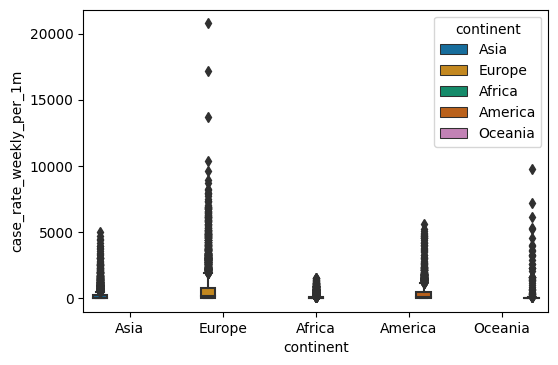

In [ ]:
#case_per_1m by continent
sns.boxplot(y='case_rate_weekly_per_1m', x='continent', 
                 data=df, 
                 palette="colorblind",
                 hue='continent')

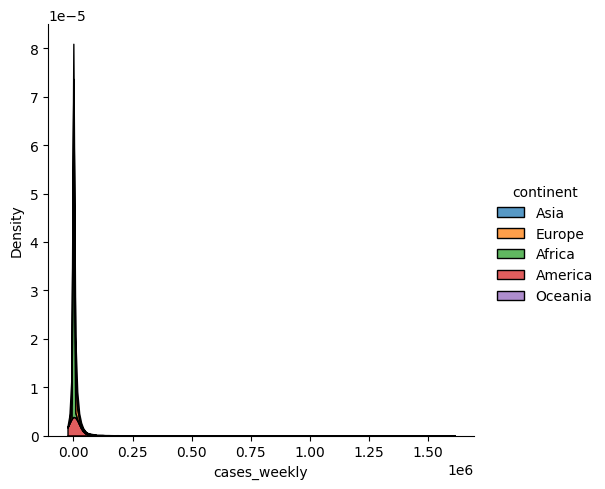

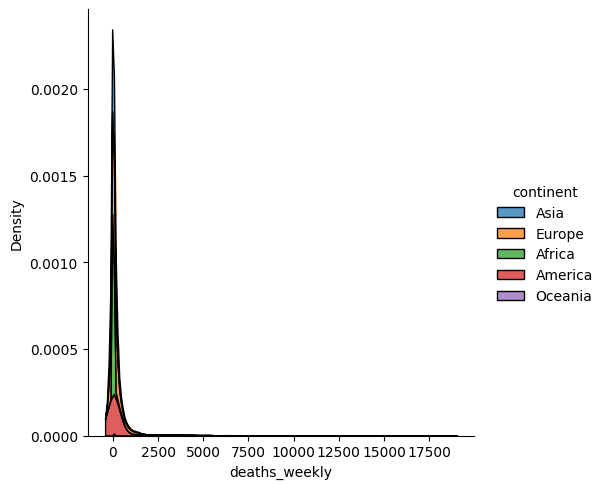

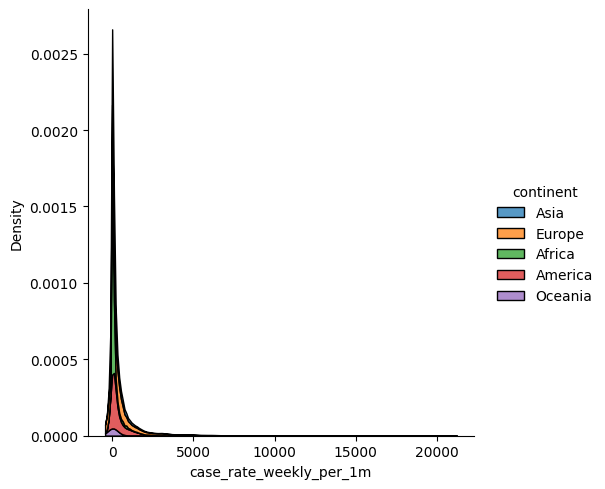

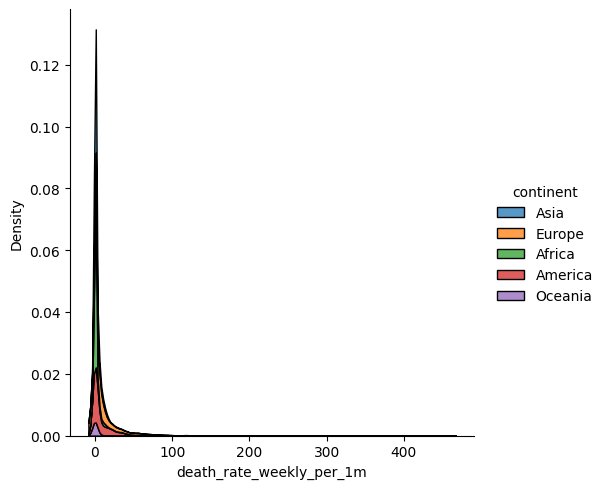

In [ ]:
#plot distribution of weekly incidence and fatality by continent as well as incidence rate and fatality rate by continent
sns.displot(df,x="cases_weekly", hue='continent', kind='kde', multiple='stack')
sns.displot(df,x="deaths_weekly", hue='continent', kind='kde', multiple='stack')
sns.displot(df, x="case_rate_weekly_per_1m", hue='continent', kind='kde', multiple='stack')
sns.displot(df, x="death_rate_weekly_per_1m", hue='continent', kind='kde', multiple='stack')

# Modeling

Data scaling and comparisons 

In [ ]:
#Scikit Learn Data Transformation Documentation: 
#https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

# select US's weekly case per 1 million people as the variable to examine the effect of different scaling techniques
US = df[df['country'].str.contains('United_States_of_America', regex=False)]
US
X = US['case_rate_weekly_per_1m'].dropna()
#Update any zero values in the data to a small value to be able to run Natural Log transformation.
X = X.replace(0,0.0000000000000000000000000001)

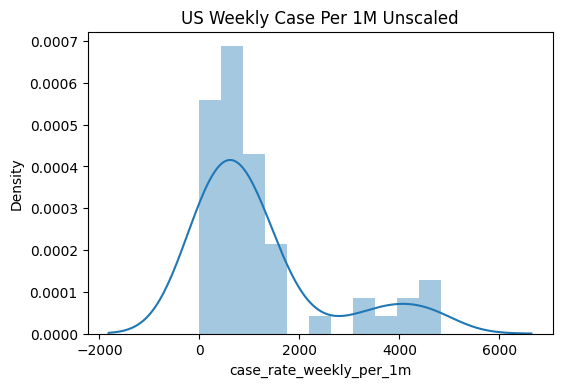

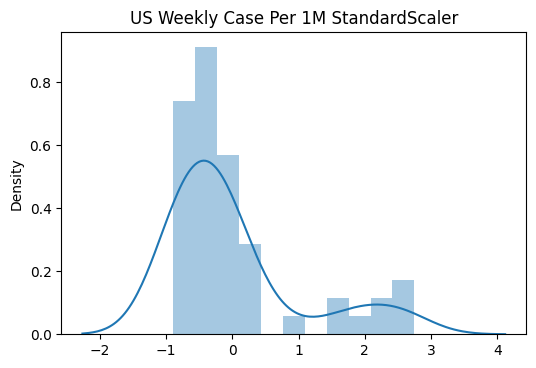

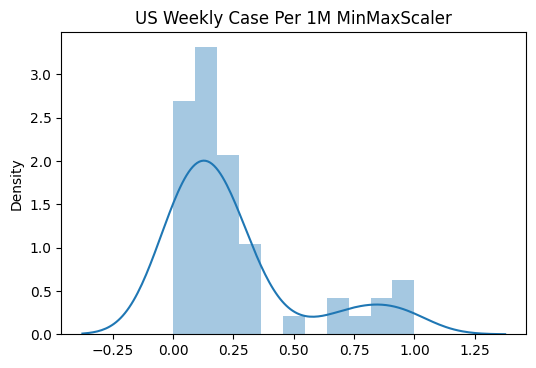

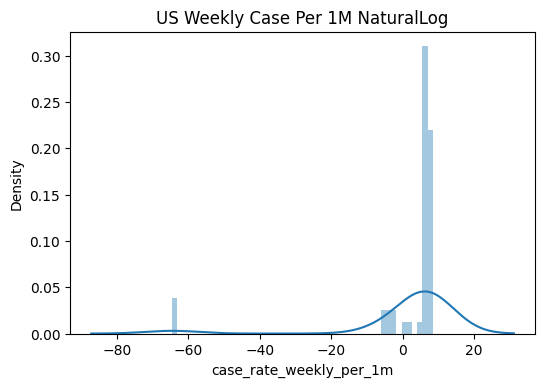

In [ ]:
# Seaborn provides a convenient way to show the effects of transformations
# on the distribution of values being transformed
unscaled_fig, ax = plt.subplots()
sns.distplot(X).set_title('US Weekly Case Per 1M Unscaled')
unscaled_fig.savefig('Transformation-Unscaled' + '.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)  

standard_fig, ax = plt.subplots()
sns.distplot(StandardScaler().fit_transform(np.array(X).reshape(-1,1))).set_title('US Weekly Case Per 1M StandardScaler')
standard_fig.savefig('Transformation-StandardScaler' + '.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)  

minmax_fig, ax = plt.subplots()
sns.distplot(MinMaxScaler().fit_transform(np.array(X).reshape(-1,1))).set_title('US Weekly Case Per 1M MinMaxScaler')
minmax_fig.savefig('Transformation-MinMaxScaler' + '.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None) 

log_fig, ax = plt.subplots()
sns.distplot(np.log(X)).set_title('US Weekly Case Per 1M NaturalLog')
log_fig.savefig('Transformation-NaturalLog' + '.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None) 

Using the Seaborn.distplot function, we are able to see the effect on the
distribution of US weekly case per 1 million people when we use different scaling techniques. For the most part, the
distribution seems un-effected when using the ‘Standard’ or ‘Min-Max’ scalers, but then the distribution skewed to the left when using a natural log transformation, which does not preserve the shape of the original distribution for the variable.

# Conclusion

**Summary:**

Globally, there is an obvious concern about the fact that the evolving COVID-19 is a worldwide public health threat. 

It is imperative that we have a better understanding of its pandemic nature. 

This assignment is aimed to use COVID19 data to conduct exploratory data analysis and help understand the spread of the disease (incidence) as well as its fatality rate.

Based on the analysis conducted in EDA section, America has the highest total number of instances and deaths between January 6, 2020 and January 4, 2021 and Europe ranks second.

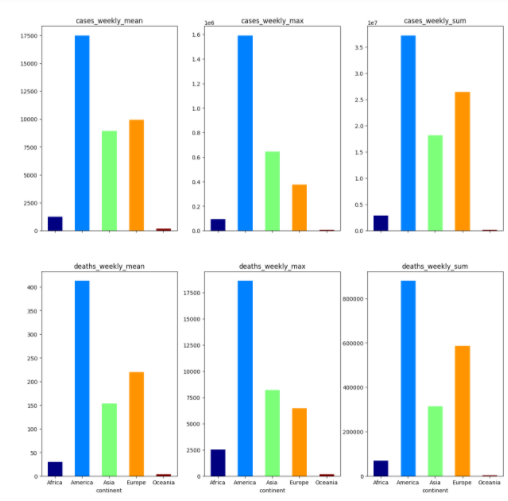

Among  the top 10 countries with most incidences, USA has the highest number of cases and is followed by India and Brazil. Notably, Italy has the highest death ratio among top 10 countries with most cases. On the other hand, though India ranked second in terms of total case numbers, its death ratio is the lowest among top 10 countries.
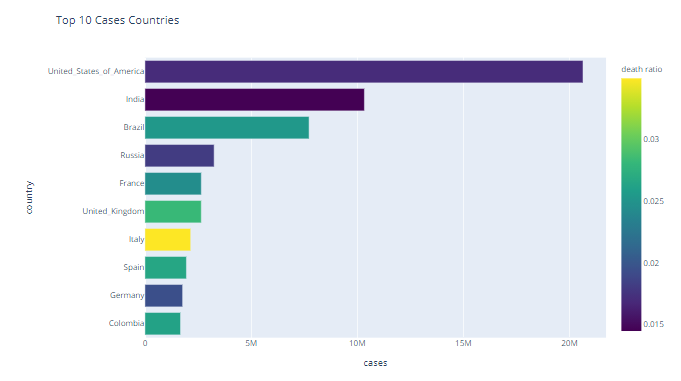 

Among top 10 countries with most deaths number, USA has the highest number of deaths and is followed by Brazil and India. Notably, though Mexico does not rank as top 10 countries with highest number of cases, it has high numbers of total deaths and is ranked at the fourth place. The death ratio of Mexico is higher than 0.08 and is the highest one among top 10 countries with most deaths.
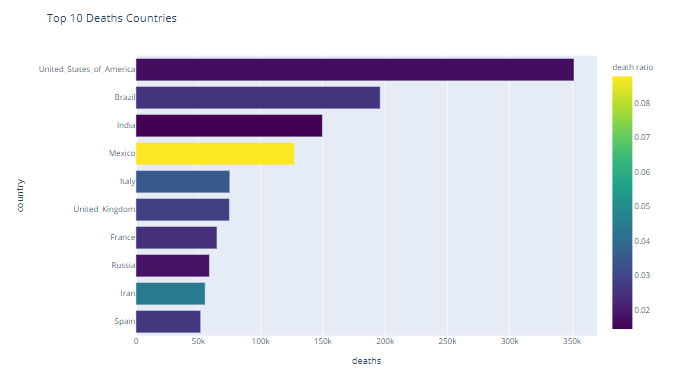

From the perspective of time, the cumulative cases worldwide increased sharply since November 2020 with a steeper slope. Similar to the observation from cumulative cases, the ramp up of deaths started in November 2020.
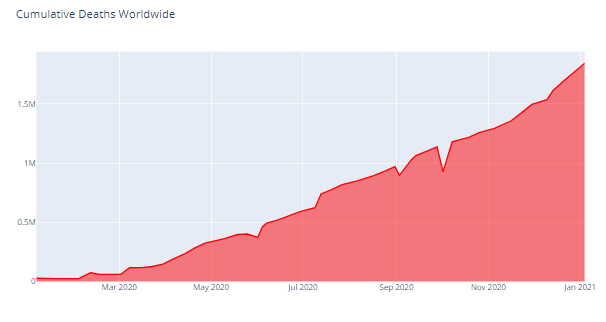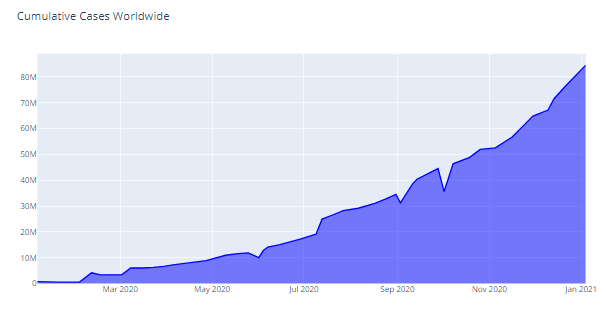

Weekly new cases and deaths numbers are varied across the time, however, there are several spikes for number of new cases and deaths. Notably, in the weeeks of July 12, 2020 and September 11, 2020, the new cases and deaths reached a high level. And also, since November 2020, both weekly new cases and deaths numbers are higher in general. In terms of weekly new death to case rate, there are several outstanding weeks across the year of 2020, such as in the weeks of February 24, 2020, April 20, 2020 and November 5, 2020, to name a few.

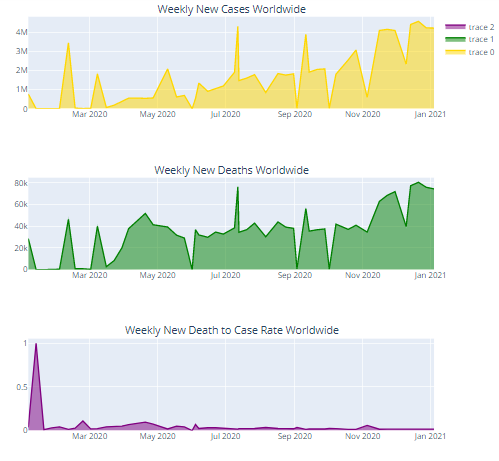

In this analysis, we also reviewed the effect of different data scaling techniques against the variable ‘US weekly case per 1M’. Using the Seaborn.distplot function, we are able to see the effect on the distribution of the data when we use different scaling techniques against the variable. For the most part, the distribution seems un-effected when using the ‘Standard’ or ‘Min-Max’ scalers, but then the distribution skewed to the left when using a natural log transformation, which does not preserve the shape of the original distribution for the variable.

**Recommendation:**

In conclusion, the first peak of outbreak of COVID-19 is around March 2020, and we observe a second upward trending of COVID-19 outbreak worldwide after September 2020. Europe and America face big challenges in controlling the sharp increase of incidences as well as deaths. As a caveat, this is an early data analysis and visualization approach of a situation that is rapidly evolving. To the best of our knowledge, this is the very first attempt on COVID‐19. However, knowledge about this virus remains limited among general people around the globe, especially with the variation of virus currently spread out in Europe. Therefore, in-depth analyses and continuous monitoring of the situation are crucial components in the management and control of this pandemic.